In [2]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

BahramFlip = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFlipp.mat')
DJFlip = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFlipp.mat')
NickFlip = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFlipp.mat')
RoohiFlip = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFlipp.mat')
SarahFlip = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFlipp.mat')


AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data'],
                            BahramFlip['Intensification_Data'],
                            DJFlip['Intensification_Data'],
                            NickFlip['Intensification_Data'],
                            RoohiFlip['Intensification_Data'],
                            SarahFlip['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label'],
                            BahramFlip['Intensification_Label'],
                            DJFlip['Intensification_Label'],
                            NickFlip['Intensification_Label'],
                            RoohiFlip['Intensification_Label'],
                            SarahFlip['Intensification_Label']), axis=0)

AllLabelOne = (AllLabels==1).reshape(-1)
AllData_LabelOne = AllData[AllLabelOne]

AllLabelZero = (AllLabels==0).reshape(-1)
AllData_LabelZero = AllData[AllLabelZero]

# Linear synthetic data augmentatiion or creation or generation
AllData_LabelOneNew_list = []

# w*data+b: translation, rotation, and scaling
# linear transformation of the target data
w, b = 1.0, 0.0
for idx in range(5):
    AllData_LabelOneNew = (w * AllData_LabelOne) + b
    AllData_LabelOneNew_list.append(AllData_LabelOneNew)
    w *= 0.9 # 1.0, 0.9, 0.81, 0.729
    b += 0.1 # 0.1, 0.2, 0.3

AllData_LabelOneNew_total = np.array(AllData_LabelOneNew_list, 
                                      dtype=AllData_LabelOne.dtype).reshape(-1, 205, 16)

AllDataNew = np.concatenate((AllData_LabelOneNew_total, AllData_LabelZero), axis=0)
AllLabelsNew = np.concatenate((AllLabels[AllLabelZero], # Tgt = 6*Non-Tgt
                                   AllLabels[AllLabelOne],
                                   AllLabels[AllLabelOne],
                                   AllLabels[AllLabelOne], 
                                   AllLabels[AllLabelOne], 
                                   AllLabels[AllLabelOne]), axis=0)

print(AllDataNew.shape, AllDataNew.dtype, AllLabelsNew.shape, AllLabelsNew.dtype)
print(np.mean(AllLabelsNew==0), np.mean(AllLabelsNew==1), np.mean(AllLabelsNew==2), np.mean(AllLabelsNew==3))
print((AllLabelsNew +  1).max(axis=0))

(62700, 205, 16) float64 (62700, 1) uint8
0.5 0.5 0.0 0.0
[2]


In [3]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllDataNew, AllLabelsNew, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(43890, 205, 16) (18810, 205, 16) (43890, 1) (18810, 1)


In [4]:
# Preparing input and output data
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.499681020734 0.500318979266 0.0
(43890, 2) float64 (18810, 2) float64


In [5]:
# Train and valid split
# from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(30723, 205, 16) (13167, 205, 16) (30723, 2) (13167, 2)


In [6]:
## Hyperparameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 307 205 16
n_classes [2]


In [7]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [8]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [10]:
# batch_size, seq_len, n_channels: 307 205 16; n_classes: [2]
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [12]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_7:0", shape=(?,), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32)
optimizer name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_conv1d_4/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_4/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_5/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_5/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_6/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_6/bias/ApplyAdam"
input: "^Adam_1/update_conv1d_7/kernel/ApplyAdam"
input: "^Adam_1/update_conv1d_7/bias/ApplyAdam"
input: "^Adam_1/update_dense_1/kernel/ApplyAdam"
input: "^Adam_1/update_dense_1/bias/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"

correct_pred, accuracy Tensor("Equal_1:0", shape=(?,), dtype=bool) Tensor("accuracy_1:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix_1/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [13]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints-dcnn/face-flip.ckpt")

Epoch: 1/100 Train loss: 0.677091 Valid loss: 0.667405 Train acc: 0.572182 Valid acc: 0.605396
Epoch: 2/100 Train loss: 0.649684 Valid loss: 0.640335 Train acc: 0.624446 Valid acc: 0.653848
Epoch: 3/100 Train loss: 0.621831 Valid loss: 0.612216 Train acc: 0.658512 Valid acc: 0.683001
Epoch: 4/100 Train loss: 0.595538 Valid loss: 0.585332 Train acc: 0.684340 Valid acc: 0.706291
Epoch: 5/100 Train loss: 0.572878 Valid loss: 0.562117 Train acc: 0.704423 Valid acc: 0.724560
Epoch: 6/100 Train loss: 0.554029 Valid loss: 0.543472 Train acc: 0.719712 Valid acc: 0.738147
Epoch: 7/100 Train loss: 0.538417 Valid loss: 0.528012 Train acc: 0.732099 Valid acc: 0.749004
Epoch: 8/100 Train loss: 0.525328 Valid loss: 0.515226 Train acc: 0.742158 Valid acc: 0.757791
Epoch: 9/100 Train loss: 0.514128 Valid loss: 0.504306 Train acc: 0.750337 Valid acc: 0.765105
Epoch: 10/100 Train loss: 0.504664 Valid loss: 0.495109 Train acc: 0.757182 Valid acc: 0.771155
Epoch: 11/100 Train loss: 0.496099 Valid loss: 0.

Epoch: 87/100 Train loss: 0.316844 Valid loss: 0.347673 Train acc: 0.864732 Valid acc: 0.853537
Epoch: 88/100 Train loss: 0.315715 Valid loss: 0.347033 Train acc: 0.865264 Valid acc: 0.853847
Epoch: 89/100 Train loss: 0.314596 Valid loss: 0.346386 Train acc: 0.865782 Valid acc: 0.854152
Epoch: 90/100 Train loss: 0.313478 Valid loss: 0.345761 Train acc: 0.866297 Valid acc: 0.854450
Epoch: 91/100 Train loss: 0.312370 Valid loss: 0.345131 Train acc: 0.866812 Valid acc: 0.854751
Epoch: 92/100 Train loss: 0.311280 Valid loss: 0.344528 Train acc: 0.867328 Valid acc: 0.855046
Epoch: 93/100 Train loss: 0.310215 Valid loss: 0.343919 Train acc: 0.867841 Valid acc: 0.855339
Epoch: 94/100 Train loss: 0.309147 Valid loss: 0.343322 Train acc: 0.868337 Valid acc: 0.855624
Epoch: 95/100 Train loss: 0.308104 Valid loss: 0.342735 Train acc: 0.868822 Valid acc: 0.855910
Epoch: 96/100 Train loss: 0.307074 Valid loss: 0.342139 Train acc: 0.869324 Valid acc: 0.856188
Epoch: 97/100 Train loss: 0.306035 Valid

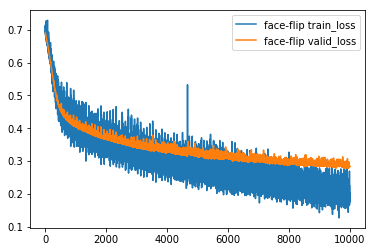

In [17]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='face-flip train_loss')
mplot.plot(valid_loss, label='face-flip valid_loss')
mplot.legend()
mplot.show()

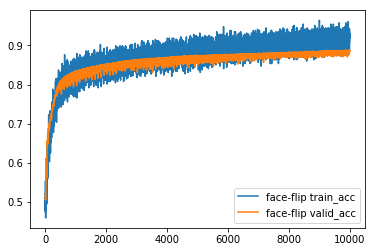

In [18]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='face-flip train_acc')
mplot.plot(valid_acc, label='face-flip valid_acc')
mplot.legend()
mplot.show()

In [20]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-dcnn'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-dcnn/face-flip.ckpt
Test loss: 0.272925 Test acc: 0.888663
